In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
#import remap



In [105]:
df = pd.read_csv("../data/Novembro/Ana Health_Tabela Modelo Previsão Churn - Tabela Geral.csv",skiprows=1)

# Criando dataframe com os dados com ocorrência única de won ou lost

In [106]:
colunas = ['id_person','state', 'city', 'postal_code', 'id_person_recommendation', 'Recebe Comunicados?', 'Interesses', 'Pontos de Atenção',
           'id_stage', 'id_org', 'status.1', 'activities_count', 'Qde Todos Atendimentos', 'Faltas Todos Atendimento', 'Datas Atendimento Médico',
           'Datas Acolhimento', 'Datas Psicoterapia','Qde Prescrições', 'Datas Prescrição', 'Qde Respostas WHOQOL']

df = df.drop(colunas, axis=1)

### Transformando a coluna de 'status' em apenas o último status

In [107]:
# def lastStatus(x):
#     if pd.isnull(x):
#         return 'none'
#     s = x.split(';')
#     return s[-1].strip()

# df['status'] = df['status'].apply(lastStatus)
def lastStatus(x):
    s = x.split(';')
    return s[-1].strip()

df['status'] = df['status'].dropna().apply(lastStatus)

In [108]:
df['status'].value_counts()

status
won     580
lost    485
Name: count, dtype: int64


Se o cliente tiver mais de um start of service é considerado o primeiro

In [109]:
def first_date(x):
    if pd.isnull(x):
        return x
    s = x.split(';')
    return s[0].strip()


df['start_of_service'] = df['start_of_service'].apply(first_date)



Se o cliente tiver com status won e lost_reason é para eliminar o lost_reason
Se estiver com status lost é considerado o último lost_reason

In [110]:
def lost_reason_lost(x,y):
    if pd.isnull(x) or pd.isnull(y):
        return None
    
    if x == 'won':
        return None
    
    s = y.split(';')
    return s[-1].strip()

In [111]:
df['lost_reason'] = df.apply(lambda row: lost_reason_lost(row['status'], row['lost_reason']), axis=1)
df['lost_reason'].value_counts()

lost_reason
[Assinatura] Desligamento                                                                   220
[Assinatura] Não quer seguir com a Ana                                                       61
[Assinatura] Empresa cancelou o benefício da Ana                                             55
[Assinatura] Precisou cortar custos                                                          27
[Assinatura] Cancelamento por inadimplência                                                  26
[Assinatura] Está sem tempo para conciliar os atendimentos                                   23
[Assinatura] Cancelamento após saída da psicoterapeuta do time da Ana                        11
[Assinatura] Não estava sentindo evolução na psicoterapia                                     7
[Assinatura] Recebeu um benefício similar da empresa e não viu sentido em manter os dois      5
[Assinatura] Desengajou após sentir melhora das questões que a levaram para psicoterapia      5
[Assinatura] Final do Piloto

In [112]:
def devolve_media(x):
    if pd.isnull(x):
        return None
    x = x.replace(',','.')
    s = x.split(';')
    s = [float(i) for i in s]
    return np.mean(s)

In [113]:
colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
for coluna in colunas_whoqol:
    df[coluna] = df[coluna].apply(devolve_media)

In [114]:
df['Físico'].describe()

count    898.000000
mean       3.645049
std        0.657525
min        1.300000
25%        3.300000
50%        3.700000
75%        4.100000
max        5.000000
Name: Físico, dtype: float64

Transformando datas em datetime

In [115]:
colunas_de_data = ['contract_start_date', 'start_of_service', 'lost_time', 'add_time', 'won_time', 'lost_time.1']
colunas_seg = ['stay_in_pipeline_stages_welcome','stay_in_pipeline_stages_first_meeting', 'stay_in_pipeline_stages_whoqol']

for coluna in colunas_seg:
    df[coluna+'_h'] = df[coluna]/3600

df = df.drop(colunas_seg, axis=1)

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [116]:
df['Problemas Abertos'].head(200)

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
                       ...                  
195    infecção por coronavírus A77 (CIAP-2)
196         dor articular do pé L17 (CIAP-2)
197                                      NaN
198                                      NaN
199                                      NaN
Name: Problemas Abertos, Length: 200, dtype: object

In [117]:
def tem_ou_nao(x):
    if pd.isnull(x) :
        return 0
    return 1

df['Problemas Abertos'] = df['Problemas Abertos'].apply(tem_ou_nao)

In [118]:
df['Problemas Abertos'].describe()


count    1201.000000
mean        0.507910
std         0.500146
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Problemas Abertos, dtype: float64

### Criando o dataframe com apenas as linhas que tem valor de status igual a won ou lost.

In [119]:
df_simple = df[df['status'].isin(['won', 'lost'])]

### Aplicando os filtros de status igual a won e data de fim de contrato igual a NaN. Além do filtro de status igual a lost e com data de fim de contrato 

In [120]:
f1 = df_simple[(df_simple['status'] == 'won') & (df_simple['contract_end_date'].isna())] 
f2 = df_simple[(df_simple['status'] == 'lost') & (df_simple['contract_end_date'].notna())] 

df_simple = pd.concat([f1, f2])

<Axes: xlabel='contract_end_date'>

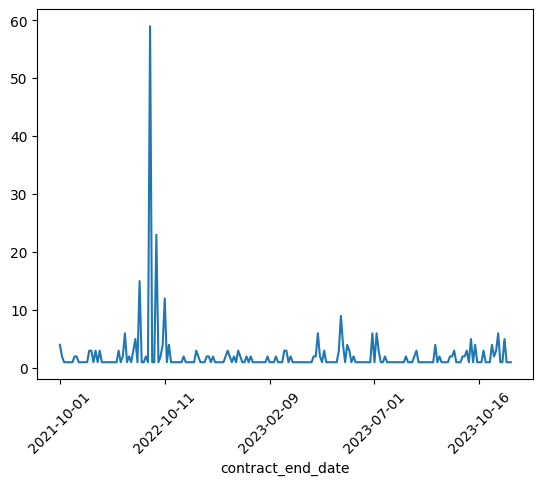

In [121]:
df_simple.groupby('contract_end_date')['status'].count().sort_index().rolling(1).sum().plot(rot=45)

### Mudando a coluna de data de começo de contrato para formato de data do pandas

In [122]:
df_simple['contract_start_date'] = pd.to_datetime(df_simple['contract_start_date'])
df_simple = df_simple.sort_values(by=['contract_start_date'])

In [123]:
df_simple['status'].value_counts()

status
won     568
lost    464
Name: count, dtype: int64

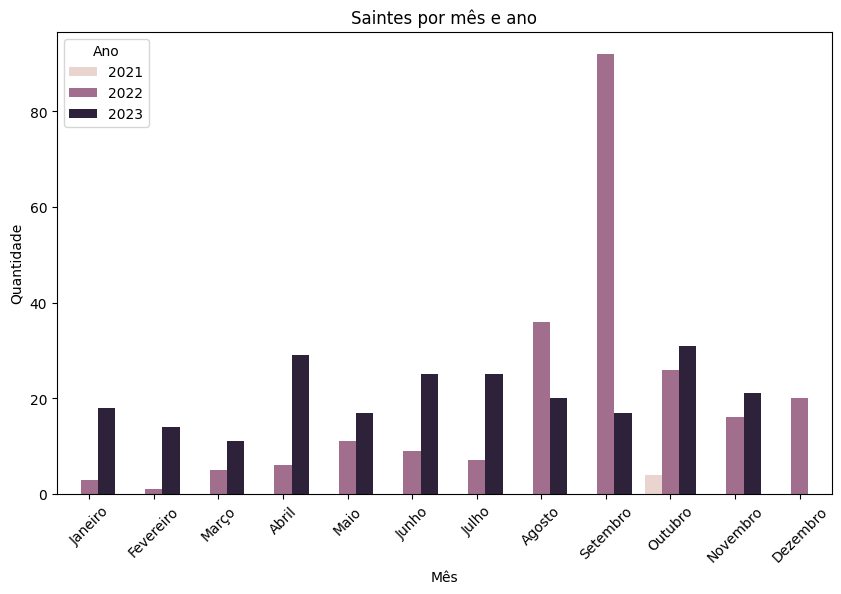

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas if not already done

# Assuming df_simple is your DataFrame

# Convert 'contract_end_date' to datetime if not already in that format
df_simple['contract_end_date'] = pd.to_datetime(df_simple['contract_end_date'])

nome_dos_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

coluna = 'contract_end_date'
new_name = coluna + '_year'
df_simple[new_name] = df_simple[coluna].dt.year

# Plotar gráfico de barras separado por ano
plt.figure(figsize=(10, 6))  # Definir tamanho da figura
# Usar seaborn para criar facetas
sns.countplot(x=df_simple[coluna].dt.month, hue=df_simple[new_name])
plt.title('Saintes por mês e ano')  # <- Fix the line ending
# Rotacionar labels do eixo x
plt.xticks(rotation=45)
# Alterar labels do eixo x
plt.xticks(np.arange(12), nome_dos_meses)
# Trocar legenda da coluna
plt.legend(title='Ano', loc='upper left', labels=['2021', '2022', '2023'])
# Trocar nome do eixo x
plt.xlabel('Mês')
# Trocar nome do eixo y
plt.ylabel('Quantidade')
plt.show()


In [125]:
colunas_de_data = ['contract_end_date']

# LEmbrar de colocar a 'contract_end_date' para time delta posteriormente

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [126]:
def ultima_mensagem(x,y):
    if (y == None):
        return "Cliente"
    
    if x>y:
        return "Cliente"
    
    else:
        return "Empresa"

In [127]:
df_aux = df_simple[df_simple['Data Última Mensagens Inbound'].notnull()]
df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
df_aux['Tempo Última Mensagem Inbound'] = df_aux['Data Última Mensagens Inbound'].apply(lambda x: (datetime.now() - x).days)
df_aux['Tempo Última Mensagem Outbound'] = df_aux['Data Última Mensagens Outbound'].apply(lambda x: (datetime.now() - x).days)

df_aux['Quem Enviou Última Mensagem'] = df_aux.apply(lambda row: ultima_mensagem(row['Tempo Última Mensagem Inbound'], row['Tempo Última Mensagem Outbound']), axis=1)


C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\4269974155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\4269974155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\4269974155.py:4: SettingWithC

In [128]:
df_aux['Quem Enviou Última Mensagem'].value_counts()
df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\3194983688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


<Axes: title={'center': 'Status dos Usuários em Relação a Última Mensagema'}, xlabel='Status Assinatura', ylabel='Quantidade Usuários'>

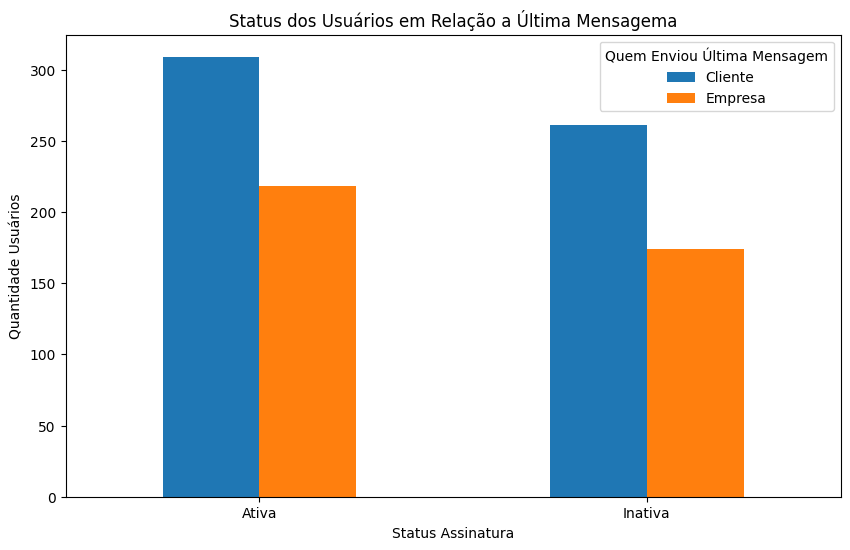

In [129]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade Usuários', title='Status dos Usuários em Relação a Última Mensagema', figsize=(10,6))


<Axes: title={'center': 'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

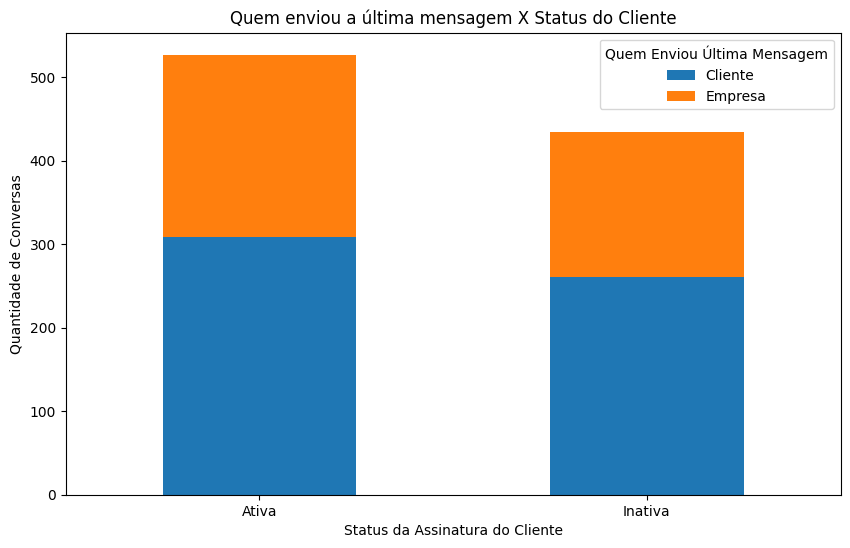

In [130]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', stacked=True, figsize=(10,6))


<Axes: title={'center': 'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

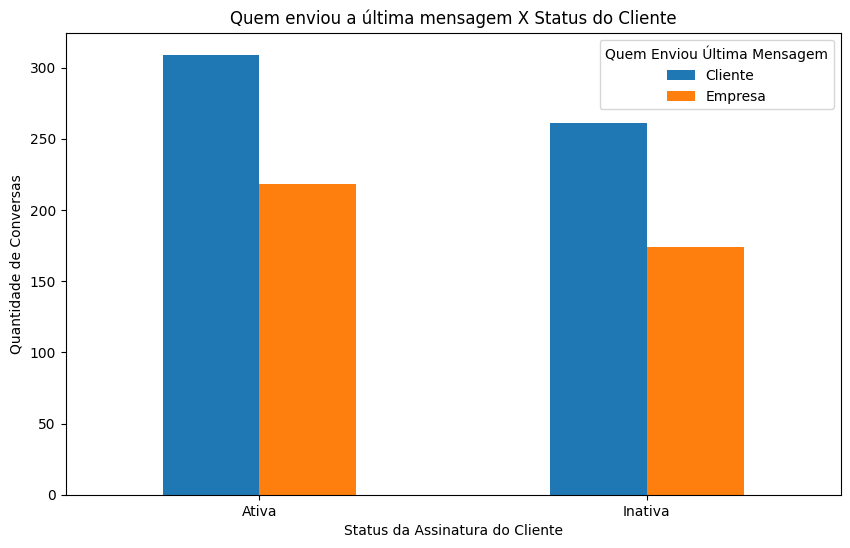

In [131]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', figsize=(10,6))


In [132]:
df_agosto = pd.read_csv('../data/Agosto/Ana Health_Tabela Modelo Previsão Churn - Tabela até 08_23.csv', skiprows=1)
df_julho = pd.read_csv('../data/Julho/Ana Health_Tabela Modelo Previsão Churn - Tabela até 07_23.csv', skiprows=1)
df_junho = pd.read_csv('../data/Junho/Ana Health_Tabela Modelo Previsão Churn - Tabela até 06_23.csv', skiprows=1)
df_novembro = pd.read_csv('../data/Novembro/Ana Health_Tabela Modelo Previsão Churn - Tabela Geral.csv', skiprows=1)
df_outubro = pd.read_csv('../data/Outubro/Ana Health_Tabela Modelo Previsão Churn - Tabela até 10_23.csv', skiprows=1)
df_setembro = pd.read_csv('../data/Setembro/Ana Health_Tabela Modelo Previsão Churn - Tabela até 09_23.csv', skiprows=1)

In [133]:
import sys
sys.path.append('..')
import scripts.script_data_basico as script_data_basico
import importlib
importlib.reload(script_data_basico)
tratamento = script_data_basico.tratamento

fim_junho = datetime(2023, 6, 30)
fim_julho = datetime(2023, 7, 31)
fim_agosto = datetime(2023, 8, 31)
fim_setembro = datetime(2023, 9, 30)
fim_outubro = datetime(2023, 10, 31)
fim_novembro = datetime(2023, 11, 30)

df_agosto = tratamento(df_agosto,fim_agosto,df_setembro)
df_julho = tratamento(df_julho, fim_julho, df_agosto)
df_junho = tratamento(df_junho, fim_junho, df_julho)
df_outubro = tratamento(df_outubro, fim_outubro, df_novembro)
df_setembro = tratamento(df_setembro, fim_setembro, df_outubro)

In [134]:
df_teste = df_outubro.copy()

df_teste['Target'] = df_teste['status_prox_mes'] == 'won'
df_teste

,id_person,birthdate,id_gender,id_marrital_status,id_health_plan,contract_start_date,contract_end_date,id_continuity_pf,Canal de Preferência,notes_count,...,Qde Total de Faturas Inadimpletes,Valor Total Inadimplência,Qde Perfis de Pagamento Inativos,Tempo até Sair,Tem Problema em Aberto,Tempo Última Mensagem Inbound,Tempo Última Mensagem Outbound,Quem Enviou Última Mensagem,status_prox_mes,Target
0,483,76.0,64.0,80.0,453.0,2021-01-27,2023-08-26,NaN,NaN,3,...,NaN,NaN,NaN,941.0,0,185.0,76.0,Cliente,lost,False
1,1259,31.0,64.0,82.0,NaN,2021-05-10,2022-09-09,338.0,NaN,1,...,NaN,NaN,NaN,487.0,1,495.0,393.0,Cliente,lost; lost,False
2,975,36.0,63.0,82.0,NaN,2021-06-28,2022-08-16,NaN,NaN,0,...,NaN,NaN,NaN,414.0,1,NaN,498.0,Empresa,lost,False
3,974,36.0,63.0,80.0,NaN,2021-06-28,2022-08-16,NaN,NaN,0,...,NaN,NaN,NaN,414.0,0,586.0,498.0,Cliente,lost,False
4,973,37.0,64.0,80.0,412.0,2021-06-28,2022-02-07,339.0,NaN,1,...,NaN,NaN,NaN,224.0,0,686.0,686.0,Empresa,lost,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,5922,27.0,63.0,82.0,NaN,2023-10-26,NaT,NaN,NaN,2,...,0.0,120.0,NaN,NaN,0,40.0,37.0,Cliente,won,True
1019,5924,31.0,63.0,82.0,NaN,2023-10-30,NaT,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,35.0,35.0,Empresa,won,True
1020,5925,22.0,64.0,80.0,NaN,2023-10-30,NaT,NaN,239.0,0,...,NaN,NaN,NaN,NaN,0,37.0,37.0,Empresa,won,True
1021,5931,23.0,64.0,82.0,NaN,2023-10-31,NaT,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,NaN,35.0,Empresa,won,True


In [135]:
corr = df_teste.corr(numeric_only=True)
corr

,id_person,birthdate,id_gender,id_marrital_status,id_health_plan,id_continuity_pf,Canal de Preferência,notes_count,done_activities_count,start_of_service,...,Valor Médio da Mensalidade,Qde Total de Faturas Pagas após Vencimento,Qde Total de Faturas Inadimpletes,Valor Total Inadimplência,Qde Perfis de Pagamento Inativos,Tempo até Sair,Tem Problema em Aberto,Tempo Última Mensagem Inbound,Tempo Última Mensagem Outbound,Target
id_person,1.000000,0.077432,0.034635,0.093865,0.004016,0.167719,-0.167700,0.082847,-0.325319,-0.977527,...,0.122653,-0.248975,-0.150559,-0.107452,NaN,-0.543733,-0.107225,-0.677998,-0.645253,0.625609
birthdate,0.077432,1.000000,-0.039207,0.472181,-0.044020,0.066643,0.006928,0.058469,0.010006,-0.076648,...,-0.004564,-0.013554,-0.080121,-0.077298,NaN,0.020770,0.008169,-0.039676,-0.069441,0.101902
id_gender,0.034635,-0.039207,1.000000,-0.039880,-0.060768,-0.082891,0.274643,0.032363,0.232119,-0.042387,...,-0.068056,-0.014729,-0.021859,-0.025159,NaN,0.048840,0.021244,-0.055995,-0.041621,0.023214
id_marrital_status,0.093865,0.472181,-0.039880,1.000000,0.011882,0.032634,-0.047522,0.048231,0.000980,-0.087899,...,-0.010010,0.099968,-0.011966,-0.003238,NaN,-0.011990,-0.004839,-0.056470,-0.080216,0.096830
id_health_plan,0.004016,-0.044020,-0.060768,0.011882,1.000000,0.023627,-0.111456,0.026103,-0.024041,0.003107,...,0.112701,-0.074128,0.007661,0.004923,NaN,0.105388,0.008478,-0.034356,-0.028832,0.009078
id_continuity_pf,0.167719,0.066643,-0.082891,0.032634,0.023627,1.000000,-0.082775,-0.124081,-0.358531,-0.175278,...,-0.045841,-0.320332,-0.107274,-0.097718,NaN,-0.262249,-0.139613,0.322684,0.293007,NaN
Canal de Preferência,-0.167700,0.006928,0.274643,-0.047522,-0.111456,-0.082775,1.000000,0.123753,0.268101,0.148131,...,-0.127379,-0.021279,-0.066728,-0.073024,NaN,0.213627,-0.017064,0.060059,0.125775,-0.093733
notes_count,0.082847,0.058469,0.032363,0.048231,0.026103,-0.124081,0.123753,1.000000,0.273727,-0.117221,...,0.029014,0.127105,-0.094520,-0.095803,NaN,0.076886,0.217444,-0.317332,-0.284381,0.176073
done_activities_count,-0.325319,0.010006,0.232119,0.000980,-0.024041,-0.358531,0.268101,0.273727,1.000000,0.287149,...,-0.030198,0.137290,0.018666,0.006003,NaN,0.450151,0.171888,-0.106598,-0.167573,-0.047662
start_of_service,-0.977527,-0.076648,-0.042387,-0.087899,0.003107,-0.175278,0.148131,-0.117221,0.287149,1.000000,...,-0.103451,0.226206,0.159210,0.116419,NaN,0.526244,0.102557,0.701346,0.667739,-0.596748


<Axes: >

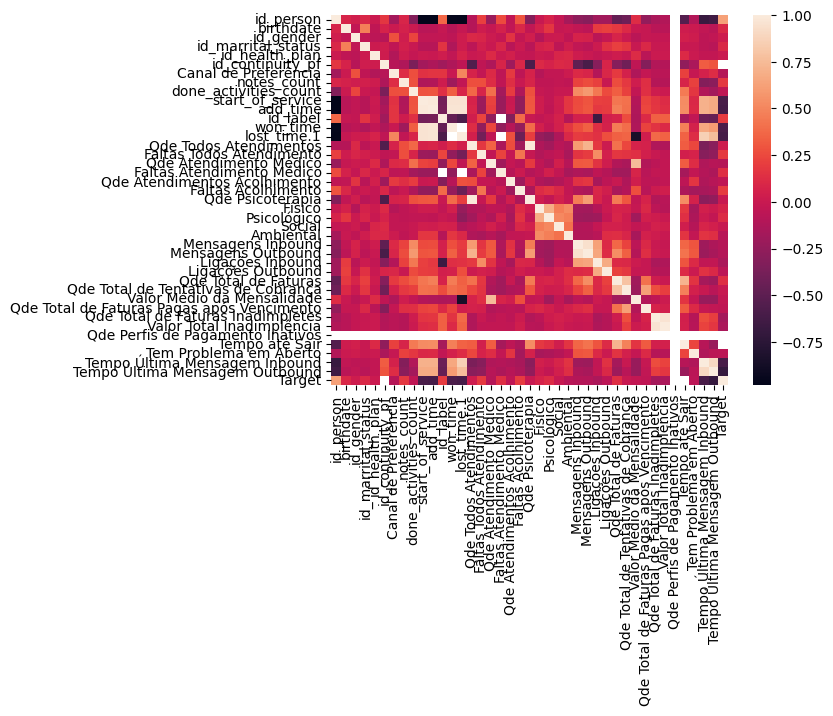

In [136]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [137]:
df_total = pd.concat([df_junho, df_julho, df_agosto, df_setembro, df_outubro])

df_total['Target'] = df_total['status_prox_mes'] == 'won'

df_total['Target'].value_counts()
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4680 entries, 0 to 1022
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   id_person                                   4680 non-null   int64         
 1   birthdate                                   4675 non-null   float64       
 2   id_gender                                   4662 non-null   float64       
 3   id_marrital_status                          4670 non-null   float64       
 4   id_health_plan                              2204 non-null   float64       
 5   contract_start_date                         4680 non-null   datetime64[ns]
 6   contract_end_date                           2292 non-null   datetime64[ns]
 7   id_continuity_pf                            1687 non-null   float64       
 8   Canal de Preferência                        1473 non-null   float64       
 9   notes_count  

<Axes: >

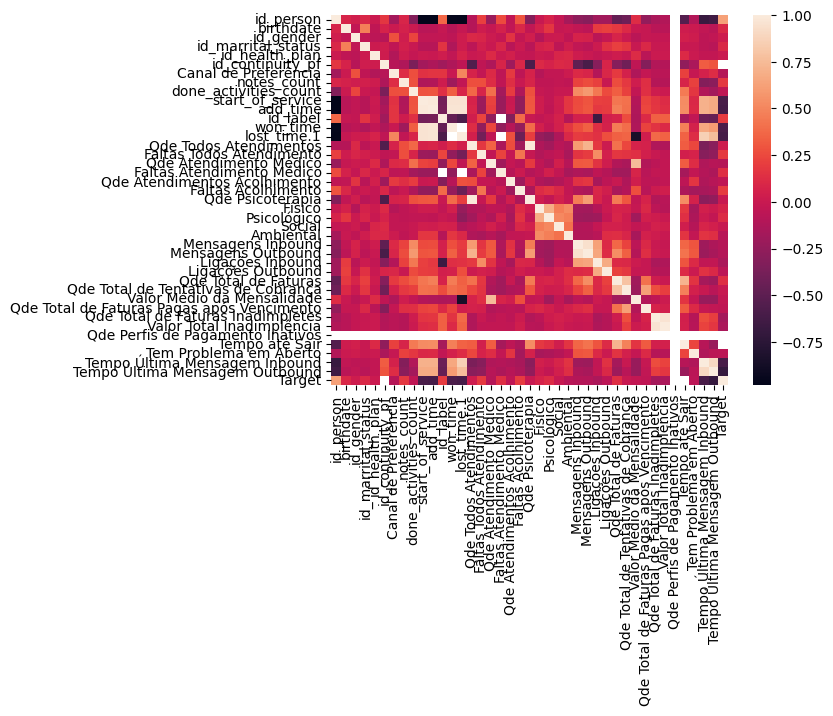

In [138]:
corr = df_teste.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

<Axes: title={'center': 'Planos de Saúde mais comuns'}>

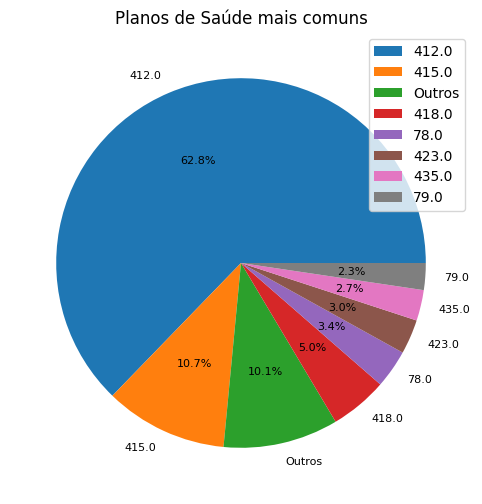

In [139]:


df_plan_mais_comum = df[df['status'] == 'won']
df_plan_mais_comum = df_plan_mais_comum[df_plan_mais_comum['id_health_plan'].notna()]

top_7_values = df_plan_mais_comum['id_health_plan'].value_counts().nlargest(7).index
df_plan_mais_comum['id_health_plan'] = df_plan_mais_comum['id_health_plan'].apply(lambda x: x if x in top_7_values else 'Outros')

df_plan_mais_comum['id_health_plan'].value_counts().plot.pie(legend=True, figsize=(10,6), title='Planos de Saúde mais comuns', ylabel='', autopct='%1.1f%%', fontsize=8)



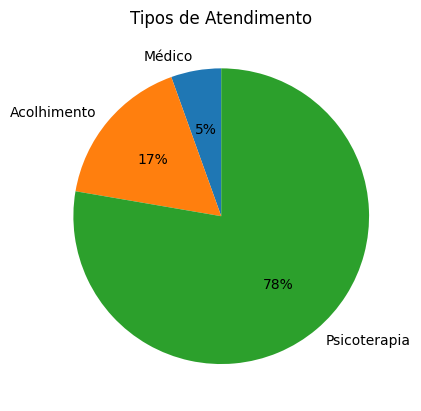

In [140]:
labels = ["Médico", "Acolhimento", "Psicoterapia"]
values = [df["Qde Atendimento Médico"].sum(), df["Qde Atendimentos Acolhimento"].sum(), df["Qde Psicoterapia"].sum()]

plt.pie(values, labels=labels, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 10})
plt.title("Tipos de Atendimento")
plt.show()



In [141]:
def retornaMensagensMais(x,y):
    if x>y:
        return 'Cliente'
    elif y>x:
        return 'Empresa'
    return 'Empate'



df_aux['Quem envia mais mensagens'] = df.apply(lambda row: retornaMensagensMais(row['Mensagens Inbound'], row['Mensagens Outbound']), axis=1)

df_aux['Quem envia mais mensagens']

C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\1887410386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Quem envia mais mensagens'] = df.apply(lambda row: retornaMensagensMais(row['Mensagens Inbound'], row['Mensagens Outbound']), axis=1)


1193    Empresa
1190    Empresa
1189     Empate
1188    Cliente
1187    Cliente
         ...   
37      Empresa
38      Cliente
39      Cliente
68      Empresa
24      Empresa
Name: Quem envia mais mensagens, Length: 962, dtype: object

<Axes: title={'center': 'Quem envia mais mensagens tem impacto na assinatura?'}, xlabel='Status Assinatura', ylabel='Número de Conversas'>

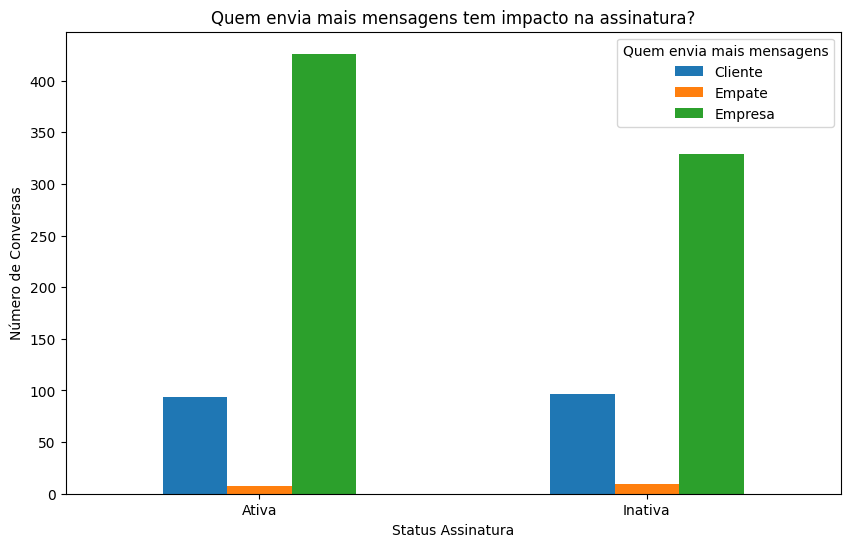

In [142]:
df_aux.groupby('Status Assinatura')['Quem envia mais mensagens'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Conversas', title='Quem envia mais mensagens tem impacto na assinatura?', figsize=(10,6))

In [143]:
bins = [0, 10, 20, 50, 100, 150, 200, np.inf]
names = ['<10', '10-19', '20-49', '50-99', '100-149', '150-199', '200+']

df_aux['Mensagens Inbound Range'] = pd.cut(df_aux['Mensagens Inbound'], bins, labels=names)

df_aux['Mensagens Outbound Range'] = pd.cut(df_aux['Mensagens Outbound'], bins, labels=names)

C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\2941231498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Mensagens Inbound Range'] = pd.cut(df_aux['Mensagens Inbound'], bins, labels=names)
C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\2941231498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Mensagens Outbound Range'] = pd.cut(df_aux['Mensagens Outbound'], bins, labels=names)


<Axes: title={'center': 'Impacto do Número de Mensagens Enviadas pela Empresa na Assinatura do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Mensagens'>

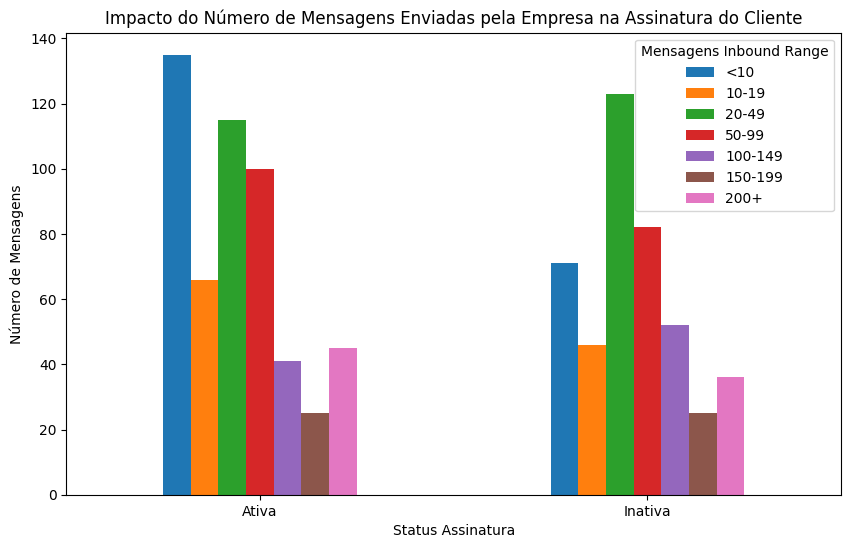

In [144]:
df_aux.groupby('Status Assinatura')['Mensagens Inbound Range'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Mensagens', title='Impacto do Número de Mensagens Enviadas pela Empresa na Assinatura do Cliente', figsize=(10,6))

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Mensagens Inbound, dtype: object

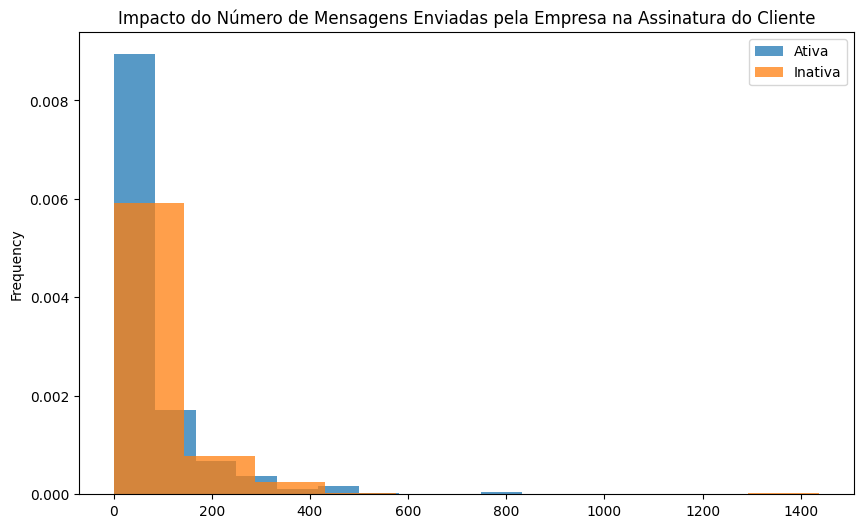

In [145]:
df_aux.groupby('Status Assinatura')['Mensagens Inbound'].plot(kind='hist', rot=0, title='Impacto do Número de Mensagens Enviadas pela Empresa na Assinatura do Cliente', figsize=(10,6), legend=True, density=True, alpha=0.75)

<Axes: title={'center': 'Impacto do Número de Mensagens Enviadas pelo Cliente na Assinatura do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Mensagens'>

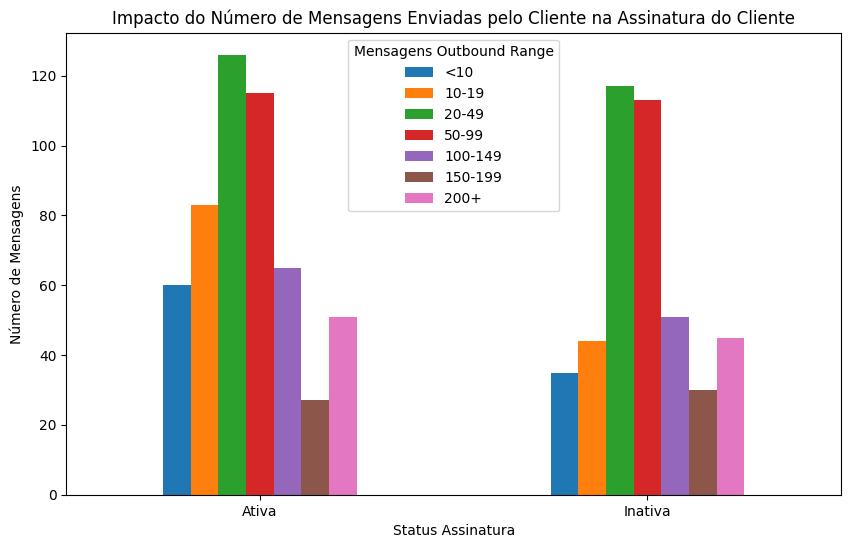

In [146]:
df_aux.groupby('Status Assinatura')['Mensagens Outbound Range'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Mensagens', title='Impacto do Número de Mensagens Enviadas pelo Cliente na Assinatura do Cliente', figsize=(10,6))

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Mensagens Outbound, dtype: object

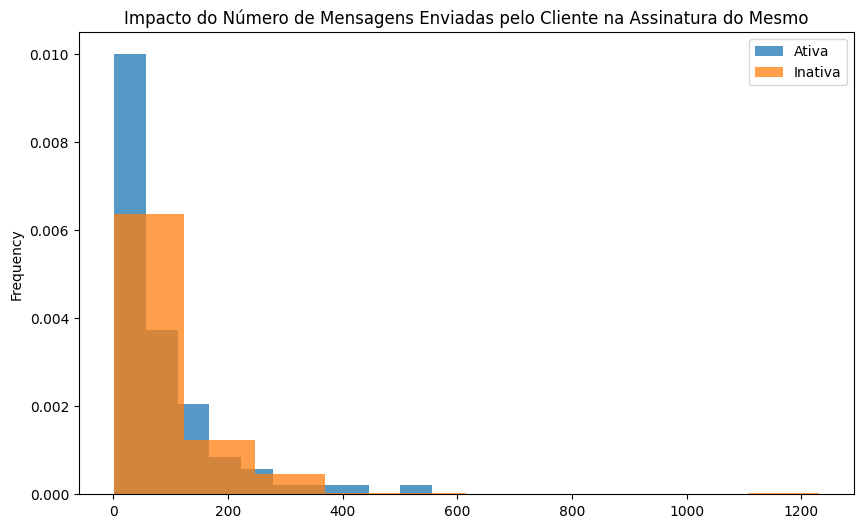

In [147]:
df_aux.groupby('Status Assinatura')['Mensagens Outbound'].plot(kind='hist', rot=0, title='Impacto do Número de Mensagens Enviadas pelo Cliente na Assinatura do Mesmo', figsize=(10,6), legend=True, density=True, alpha=0.75)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Ligações Inbound, dtype: object

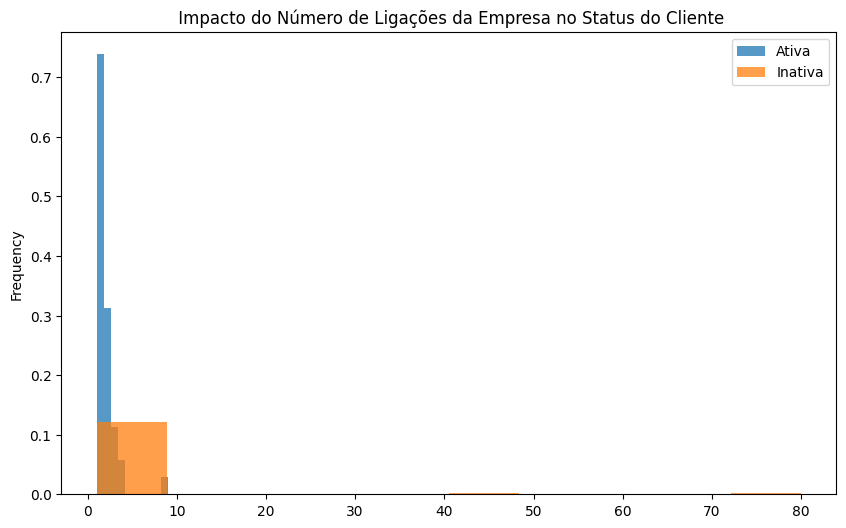

In [148]:
df_aux.groupby('Status Assinatura')['Ligações Inbound'].plot(kind='hist', rot=0, title=' Impacto do Número de Ligações da Empresa no Status do Cliente', figsize=(10,6), legend=True, density=True, alpha=0.75)

<Axes: title={'center': 'Impacto do Número de Ligações do Usuário no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

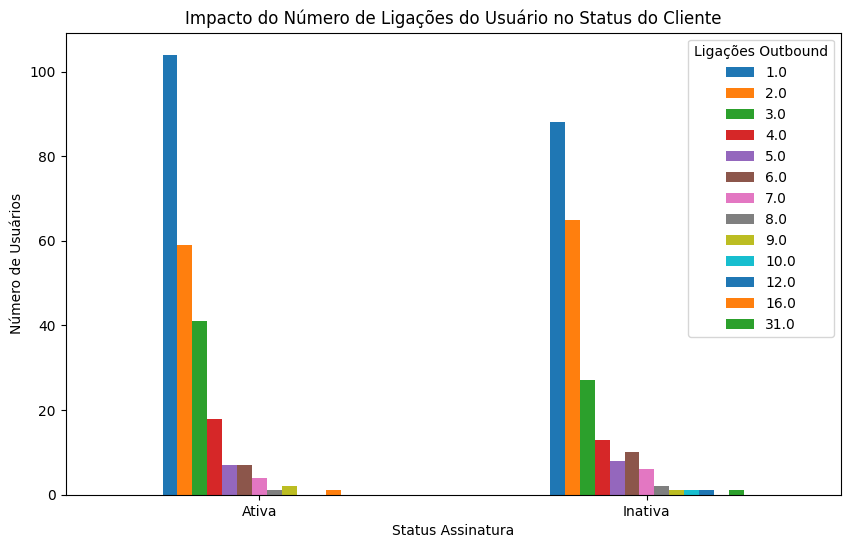

In [149]:
df_aux.groupby('Status Assinatura')['Ligações Outbound'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Impacto do Número de Ligações do Usuário no Status do Cliente', figsize=(10,6))

In [150]:
def retornaMensagensMais(x,y):
    if x>y:
        return 'Cliente'
    elif y>x:
        return 'Empresa'
    return 'Empate'



df_aux['Quem liga mais'] = df.apply(lambda row: retornaMensagensMais(row['Ligações Inbound'], row['Ligações Outbound']), axis=1)

df_aux['Quem liga mais']

C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\4072466146.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Quem liga mais'] = df.apply(lambda row: retornaMensagensMais(row['Ligações Inbound'], row['Ligações Outbound']), axis=1)


1193     Empate
1190     Empate
1189     Empate
1188     Empate
1187     Empate
         ...   
37       Empate
38       Empate
39       Empate
68       Empate
24      Empresa
Name: Quem liga mais, Length: 962, dtype: object

<Axes: title={'center': 'Impacto de Quem Faz Mais Ligações no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

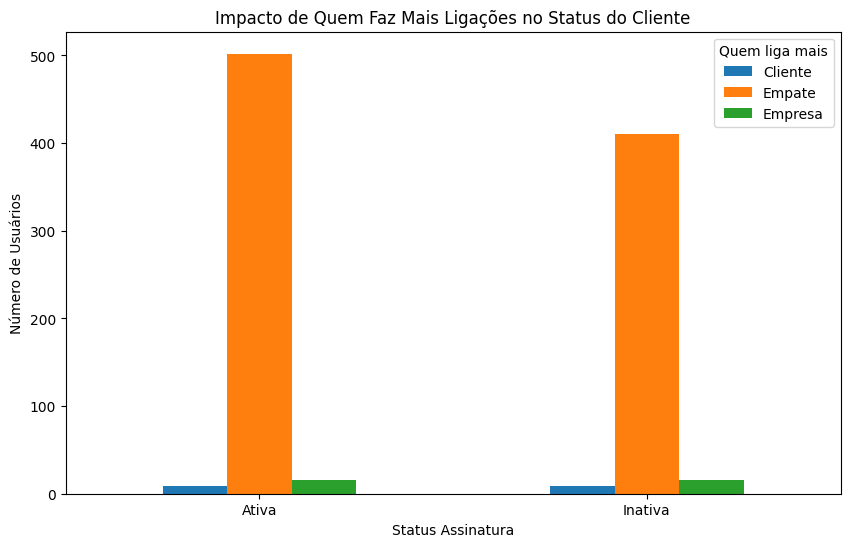

In [151]:
df_aux.groupby('Status Assinatura')['Quem liga mais'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Impacto de Quem Faz Mais Ligações no Status do Cliente', figsize=(10,6))

In [152]:
df_aux['Qde Atendimento Médico'].describe()

count    203.000000
mean       1.689655
std        1.521217
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Qde Atendimento Médico, dtype: float64

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Qde Atendimento Médico, dtype: object

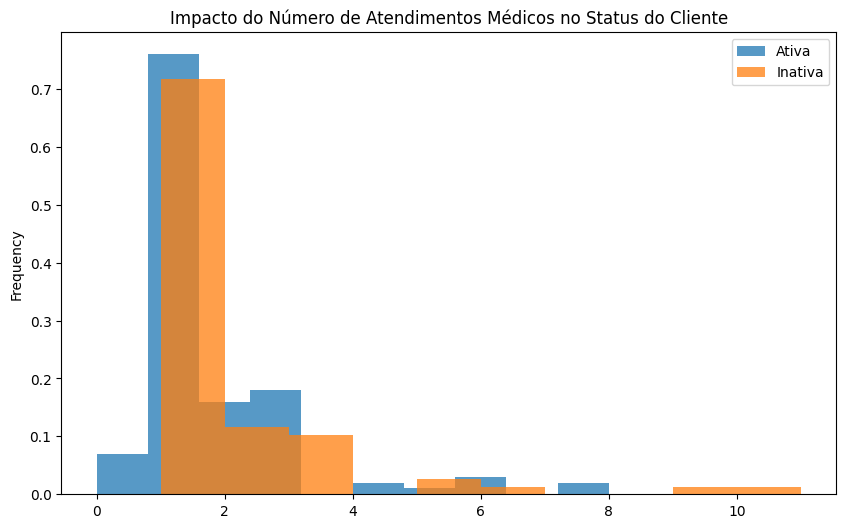

In [153]:
df_aux.groupby('Status Assinatura')['Qde Atendimento Médico'].plot(kind='hist', rot=0, title='Impacto do Número de Atendimentos Médicos no Status do Cliente', figsize=(10,6), legend=True, density=True, alpha=0.75)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Faltas Atendimento Médico, dtype: object

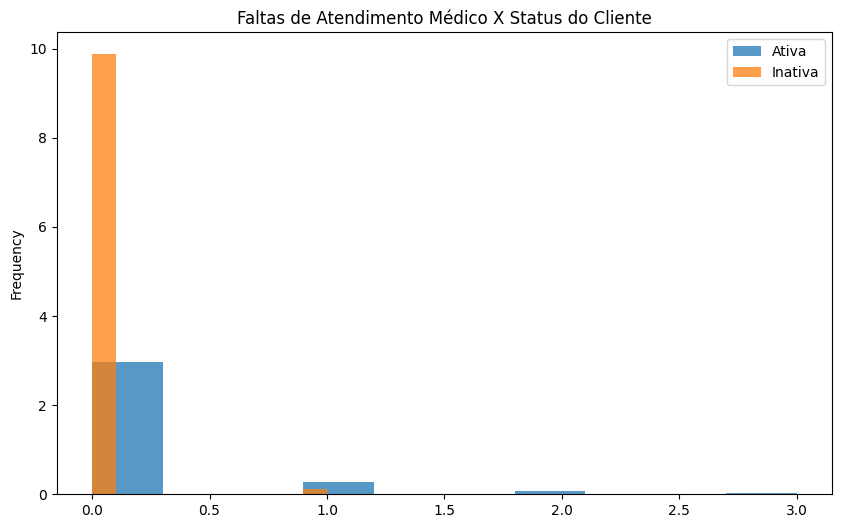

In [154]:
df_aux.groupby('Status Assinatura')['Faltas Atendimento Médico'].plot(kind='hist', rot=0, title='Faltas de Atendimento Médico X Status do Cliente', figsize=(10,6), legend=True, density=True, alpha=0.75)

In [155]:
df_aux['Qde Psicoterapia'].describe()

count    423.000000
mean      11.638298
std       11.667354
min        1.000000
25%        3.000000
50%        8.000000
75%       17.000000
max       65.000000
Name: Qde Psicoterapia, dtype: float64

In [156]:
bins = [0, 10, 20, 30, 40, 50, np.inf]
names = ['<10', '10-19', '20-29', '30-39', '40-49', '50+']

df_aux['Qde Psicoterapia Range'] = pd.cut(df_aux['Qde Psicoterapia'], bins, labels=names)

C:\Users\Gustavin\AppData\Local\Temp\ipykernel_32256\1319644578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Qde Psicoterapia Range'] = pd.cut(df_aux['Qde Psicoterapia'], bins, labels=names)


Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Qde Psicoterapia, dtype: object

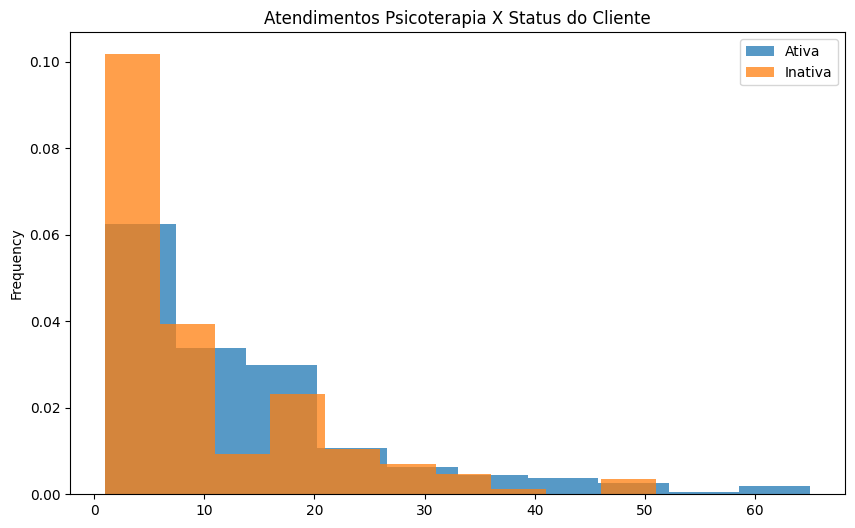

In [157]:
df_aux.groupby('Status Assinatura')['Qde Psicoterapia'].plot(kind='hist', title='Atendimentos Psicoterapia X Status do Cliente', figsize=(10,6), legend=True, alpha=0.75, density=True)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Faltas Psicoterapia, dtype: object

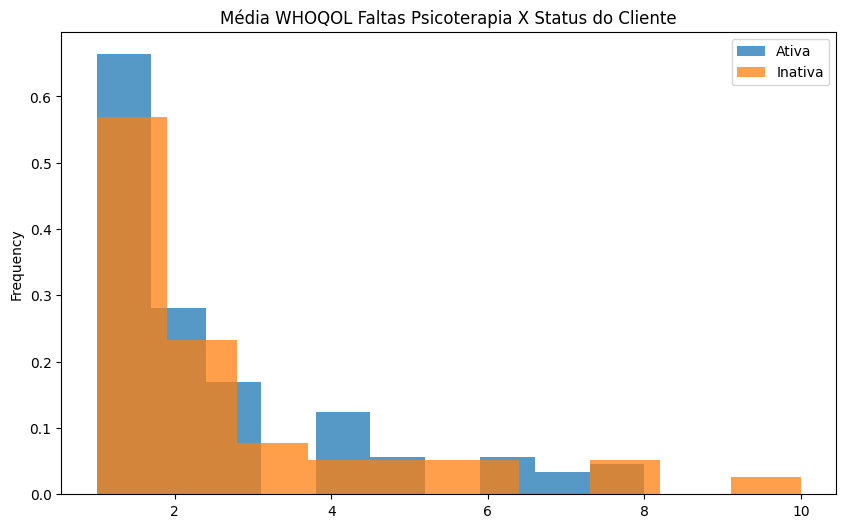

In [158]:
df_aux.groupby('Status Assinatura')['Faltas Psicoterapia'].plot(kind='hist', title='Média WHOQOL Faltas Psicoterapia X Status do Cliente', figsize=(10,6), legend=True, alpha=0.75, density=True)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Físico, dtype: object

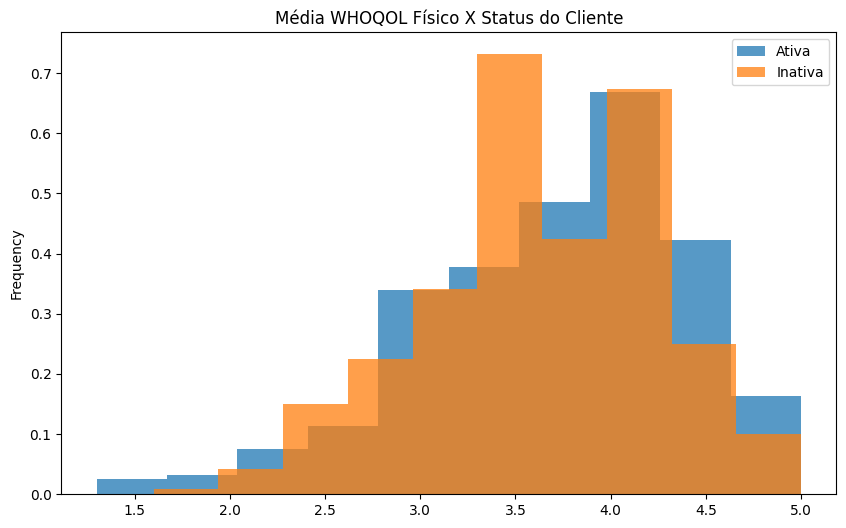

In [159]:
df_aux.groupby('Status Assinatura')['Físico'].plot(kind='hist', title='Média WHOQOL Físico X Status do Cliente', figsize=(10,6), legend=True, alpha=0.75, density=True)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Psicológico, dtype: object

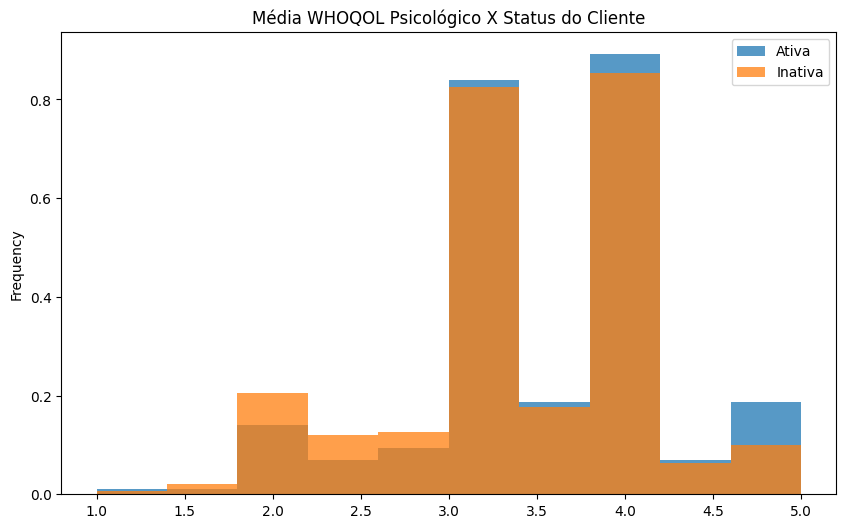

In [160]:
df_aux.groupby('Status Assinatura')['Psicológico'].plot(kind='hist', title='Média WHOQOL Psicológico X Status do Cliente', figsize=(10,6), legend=True, alpha=0.75, density=True)

Status Assinatura
Ativa      Axes(0.125,0.11;0.775x0.77)
Inativa    Axes(0.125,0.11;0.775x0.77)
Name: Social, dtype: object

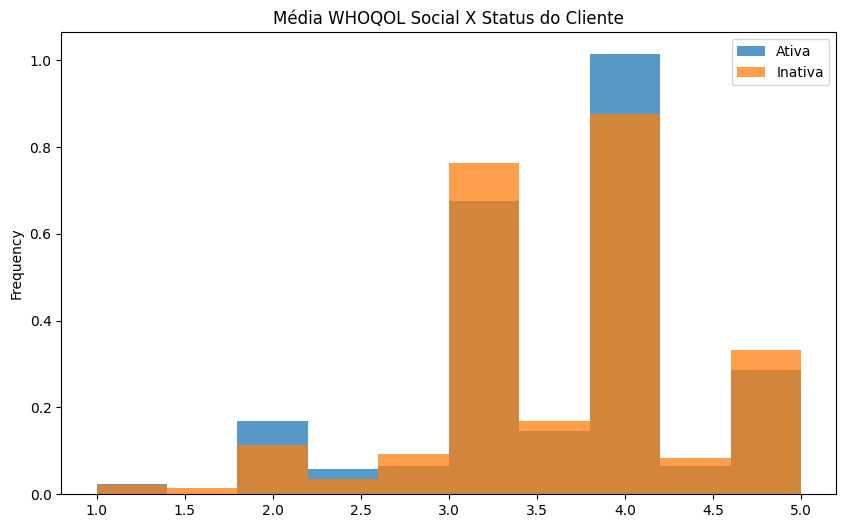

In [161]:
df_aux.groupby('Status Assinatura')['Social'].plot(kind='hist', title='Média WHOQOL Social X Status do Cliente', figsize=(10,6), legend=True, alpha=0.75, density=True)